# Tutorial 1: Reinforcement Learning For Games

**Week 3, Day 5: Learning to Play Games & DL Thinking 3**

**By Neuromatch Academy**

__Content creators:__ Mandana Samiei, Raymond Chua, Kushaan Gupta, Tim Lilicrap, Blake Richards

__Content reviewers:__ Arush Tagade, Lily Cheng, Melvin Selim Atay, Kelson Shilling-Scrivo

__Content editors:__ Melvin Selim Atay, Spiros Chavlis, Gunnar Blohm

__Production editors:__ Namrata Bafna, Gagana B, Spiros Chavlis

---
# Tutorial Objectives

In this tutorial, you will learn how to implement a game loop, create a random player, and improve the performance of player using different reinforcement learning methods.

The specific objectives for this tutorial:
*   Understand the format of two-players games, Othello specifically
*   Understand how to create random players
*   Understand how to implement a value-based player
*   Understand how to implement a policy-based player
*   Understand how to implement a player with Monte Carlo planner

In [ ]:
# @title Tutorial slides
from IPython.display import IFrame
link_id = "3zn9w"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup

In [1]:
# @title Install dependencies
!pip install coloredlogs --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.4 MB/s eta 0:00:00


In [2]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_dl",
            "user_key": "f379rz8y",
        },
    ).render()


feedback_prefix = "W3D5_T1"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.1 MB/s eta 0:00:00


In [3]:
# Imports
import os
import time
import random
import logging
import coloredlogs

import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm
from pickle import Unpickler

log = logging.getLogger(__name__)
coloredlogs.install(level='INFO')  # Change this to DEBUG to see more info.

In [4]:
# @title Helper functions

def loadTrainExamples(folder, filename):
  """
  Helper function to load training examples

  Args:
    folder: string
      Path specifying training examples
    filename: string
      File name of training examples

  Returns:
    trainExamplesHistory: list
      Returns examples based on the model were already collected (loaded)
  """
  trainExamplesHistory = []
  modelFile = os.path.join(folder, filename)
  examplesFile = modelFile + ".examples"
  if not os.path.isfile(examplesFile):
    print(f'File "{examplesFile}" with trainExamples not found!')
    r = input("Continue? [y|n]")
    if r != "y":
      sys.exit()
  else:
    print("File with train examples found. Loading it...")
    with open(examplesFile, "rb") as f:
      trainExamplesHistory = Unpickler(f).load()
    print('Loading done!')
    return trainExamplesHistory


def save_model_checkpoint(folder, filename, nnet):
  filepath = os.path.join(folder, filename)

  if not os.path.exists(folder):
    print(f"Checkpoint Directory does not exist! Making directory {folder}")
    os.mkdir(folder)
  else:
    print("Checkpoint Directory exists!")

  torch.save({'state_dict': nnet.state_dict()}, filepath)
  print("Model saved!")


def load_model_checkpoint(folder, filename, nnet, device):
  filepath = os.path.join(folder, filename)

  if not os.path.exists(filepath):
    raise FileNotFoundError(f"No model in path {filepath}")

  checkpoint = torch.load(filepath, map_location=device)
  nnet.load_state_dict(checkpoint['state_dict'])

In [5]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [6]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [7]:
SEED = 2023
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2023 has been set.


In [8]:
# @title Download the modules

# @markdown Run this cell!

# @markdown Download from OSF. The original repo is https://github.com/raymondchua/nma_rl_games.git

import os, io, sys, shutil, zipfile
from urllib.request import urlopen

# download from github repo directly
#!git clone git://github.com/raymondchua/nma_rl_games.git --quiet
REPO_PATH = 'nma_rl_games'

if not os.path.exists(REPO_PATH):
  download_string = "Downloading"
  zipurl = 'https://osf.io/kf4p9/download'
  print(f"{download_string} and unzipping the file... Please wait.")
  with urlopen(zipurl) as zipresp:
    with zipfile.ZipFile(io.BytesIO(zipresp.read())) as zfile:
      zfile.extractall()
  print("Download completed.")

# add the repo in the path
sys.path.append('nma_rl_games/alpha-zero')
print(f"Added the {REPO_PATH} in the path and imported the modules.")

# @markdown Import modules designed for use in this notebook
import Arena

from utils import *
from Game import Game
from MCTS import MCTS
from NeuralNet import NeuralNet

# from othello.OthelloPlayers import *
from othello.OthelloLogic import Board
# from othello.OthelloGame import OthelloGame
from othello.pytorch.NNet import NNetWrapper as NNet

Download completed.
Added the nma_rl_games in the path and imported the modules.


The hyperparameters used throughout the notebook.

In [9]:
args = dotdict({
    'numIters': 1,            # In training, number of iterations = 1000 and num of episodes = 100
    'numEps': 1,              # Number of complete self-play games to simulate during a new iteration.
    'tempThreshold': 15,      # To control exploration and exploitation
    'updateThreshold': 0.6,   # During arena playoff, new neural net will be accepted if threshold or more of games are won.
    'maxlenOfQueue': 200,     # Number of game examples to train the neural networks.
    'numMCTSSims': 15,        # Number of games moves for MCTS to simulate.
    'arenaCompare': 10,       # Number of games to play during arena play to determine if new net will be accepted.
    'cpuct': 1,
    'maxDepth': 5,             # Maximum number of rollouts
    'numMCsims': 5,           # Number of monte carlo simulations
    'mc_topk': 3,             # Top k actions for monte carlo rollout

    'checkpoint': './temp/',
    'load_model': False,
    'load_folder_file': ('/dev/models/8x100x50','best.pth.tar'),
    'numItersForTrainExamplesHistory': 20,

    # Define neural network arguments
    'lr': 0.001,               # lr: Learning Rate
    'dropout': 0.3,
    'epochs': 10,
    'batch_size': 64,
    'device': DEVICE,
    'num_channels': 512,
})

---
# Section 0: Introduction

In [ ]:
# @title Video 0: Introduction
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '5kQ-xGbjlJo'), ('Bilibili', 'BV1kq4y1H7MQ')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [10]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Introduction_Video")

---
# Section 1: Create a game/agent loop for RL

*Time estimate: ~15 mins*

In [11]:
# @title Video 1: A game loop for RL
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'aH2Hs8f6KrQ'), ('Bilibili', 'BV1iw411979L')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_A_game_loop_for_RL_Video")

## Section 1.1: Introduction to OthelloGame

Othello is a board game played by two players on a board of 64 squares arranged in an eight-by-eight grid, with 64 playing pieces that are black on one side and white on the other.

**Setup**:
The board will start with 2 black discs and 2 white discs at the centre of the board. They are arranged with black forming a North-East to South-West direction. White is forming a North-West to South-East direction. Each player gets 32 discs and black always starts the game.

**Game rules**:
* Players take turns placing a single disk at a time.
* A move is made by placing a disc of the player's color on the board to surround (i.e. "outflank") discs of the opposite color. In other words, the player with black discs must place on so that there is a straight line between the newly placed disc and another black disc, with one or more white pieces between them.
* Surrounded disks get flipped (i.e. change color).
* If a player does not have a valid move (they cannot place their disc to outflank the oppponent's discs), they pass on their turn
* A player can not voluntarily forfeit his turn.
* When both players can not make a valid move the game ends.

If you're interested, you can explore this website, https://www.eothello.com/, where you will find a collection of useful rules and diagrams. Additionally, you can even play a sample Othello game on the site if you wish!

**Note**: we will use a 6x6 board to speed computations up


***Goal***: Setup a game environment with multiple players for reinforcement learning experiments.

***Exercise***:

*   Build an agent that plays random moves
*   Make agents play games and compute wins and losses

Execute the following code to enable the `OthelloGame` class. This class represents a game board and has methods such `getInitBoard` to create the intial board, `getValidMove` to return the options of valid moves, and other helpful functionality to play the game. You do not need to understand every line of code in this tutorial, but try to develop an intuitive understanding of the methods.

In [12]:
class OthelloGame(Game):
  """
  Othello game board
  """
  square_content = {
      -1: "X",
      +0: "-",
      +1: "O"
      }

  @staticmethod
  def getSquarePiece(piece):
    return OthelloGame.square_content[piece]

  def __init__(self, n):
    self.n = n

  def getInitBoard(self):
    b = Board(self.n)
    return np.array(b.pieces)

  def getBoardSize(self):
    return (self.n, self.n)

  def getActionSize(self):
    # Return number of actions, n is the board size and +1 is for no-op action
    return self.n * self.n + 1

  def getCanonicalForm(self, board, player):
    # Return state if player==1, else return -state if player==-1
    return player * board

  def stringRepresentation(self, board):
    return board.tobytes()

  def stringRepresentationReadable(self, board):
    board_s = "".join(self.square_content[square] for row in board for square in row)
    return board_s

  def getScore(self, board, player):
    b = Board(self.n)
    b.pieces = np.copy(board)
    return b.countDiff(player)

  @staticmethod
  def display(board):
    n = board.shape[0]
    print("   ", end="")
    for y in range(n):
      print(y, end=" ")
    print("")
    print("-----------------------")
    for y in range(n):
      print(y, "|", end="")    # Print the row
      for x in range(n):
        piece = board[y][x]    # Get the piece to print
        print(OthelloGame.square_content[piece], end=" ")
      print("|")
    print("-----------------------")

  @staticmethod
  def displayValidMoves(moves):
    A=np.reshape(moves[0:-1], board.shape)
    n = board.shape[0]
    print("  ")
    print("possible moves")
    print("   ", end="")
    for y in range(n):
      print(y, end=" ")
    print("")
    print("-----------------------")
    for y in range(n):
      print(y, "|", end="")    # Print the row
      for x in range(n):
        piece = A[y][x]    # Get the piece to print
        print(OthelloGame.square_content[piece], end=" ")
      print("|")
    print("-----------------------")

  def getNextState(self, board, player, action):
    """
    Make valid move. If player takes action on board, return next (board,player)
    and action must be a valid move

    Args:
      board: np.ndarray
        Board of size n x n [6x6 in this case]
      player: Integer
        ID of current player
      action: np.ndarray
        Space of actions

    Returns:
      (board, player): tuple
        Next state representation
    """
    if action == self.n*self.n:
      return (board, -player)
    b = Board(self.n)
    b.pieces = np.copy(board)
    move = (int(action/self.n), action%self.n)
    b.execute_move(move, player)
    return (b.pieces, -player)

  def getValidMoves(self, board, player):
    """
    Get all valid moves for player

    Args:
      board: np.ndarray
        Board of size n x n [6x6 in this case]
      player: Integer
        ID of current player
      action: np.ndarray
        Space of action

    Returns:
      valids: np.ndarray
        Valid moves for player
    """
    valids = [0]*self.getActionSize()
    b = Board(self.n)
    b.pieces = np.copy(board)
    legalMoves =  b.get_legal_moves(player)
    if len(legalMoves)==0:
      valids[-1]=1
      return np.array(valids)
    for x, y in legalMoves:
      valids[self.n*x+y]=1
    return np.array(valids)

  def getGameEnded(self, board, player):
    """
    Check if game ended

    Args:
      board: np.ndarray
        Board of size n x n [6x6 in this case]
      player: Integer
        ID of current player

    Returns:
      0 if not ended, 1 if player 1 won, -1 if player 1 lost
    """
    b = Board(self.n)
    b.pieces = np.copy(board)
    if b.has_legal_moves(player):
      return 0
    if b.has_legal_moves(-player):
      return 0
    if b.countDiff(player) > 0:
      return 1
    return -1

  def getSymmetries(self, board, pi):
    """
    Get mirror/rotational configurations of board

    Args:
      board: np.ndarray
        Board of size n x n [6x6 in this case]
      pi: np.ndarray
        Dimension of board

    Returns:
      l: list
        90 degree of board, 90 degree of pi_board
    """
    assert(len(pi) == self.n**2+1)  # 1 for pass
    pi_board = np.reshape(pi[:-1], (self.n, self.n))
    l = []

    for i in range(1, 5):
      for j in [True, False]:
        newB = np.rot90(board, i)
        newPi = np.rot90(pi_board, i)
        if j:
          newB = np.fliplr(newB)
          newPi = np.fliplr(newPi)
        l += [(newB, list(newPi.ravel()) + [pi[-1]])]
    return l

Below, we initialize and view a board.

In [13]:
# Set up the game
game = OthelloGame(6)

# Get the initial board
board = game.getInitBoard()

# Display the board
game.display(board)

# Observe the game board size
print(f'Board size = {game.getBoardSize()}')

# Observe the action size
print(f'Action size = {game.getActionSize()}')

   0 1 2 3 4 5 
-----------------------
0 |- - - - - - |
1 |- - - - - - |
2 |- - X O - - |
3 |- - O X - - |
4 |- - - - - - |
5 |- - - - - - |
-----------------------
Board size = (6, 6)
Action size = 37


Now let's look at the valid actions for player 1 (the circles) and compare the valid actions to the board above.

In [14]:
# Get valid moves
valids = game.getValidMoves(board, 1)
print(valids)

# Visualize the moves
game.displayValidMoves(valids)

[0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
  
possible moves
   0 1 2 3 4 5 
-----------------------
0 |- - - - - - |
1 |- - O - - - |
2 |- O - - - - |
3 |- - - - O - |
4 |- - - O - - |
5 |- - - - - - |
-----------------------


`game.getValidMoves` returns 1s and 0s for every position on the board, 1 indicates if it is a valid place to put a new disc. Note that it turns a list (this could be reshaped into the board shape).

We also have a method to visualize the valid actions on the board.

## Section 1.2: Create a random player

Let's start by setting up the game loop using a random player to start with so that we we can test the game loop and make sure it works correctly.

To do so, we will first implement a random player in 3 steps:
1. determine which moves are possible at all
2. assign a uniform probability to each more (remember, this is a random player): 1/N for N valid moves
3. randomly choose a move from the possible moves

### Coding Exercise 1.2: Implement a random player

In [16]:
class RandomPlayer():

  def __init__(self, game):
    self.game = game

  def play(self, board):
    """
    Args:
      board: np.ndarray
        Board of size n x n [6x6 in this case]

    Returns:
      a: int
        Randomly chosen move
    """

    # Compute the valid moves using getValidMoves()
    valids = self.game.getValidMoves(board, 1)

    # Compute the probability of each move being played (random player means
    # this should be uniform for valid moves, 0 for others)
    prob = valids/valids.sum()

    # Pick a random action based on the probabilities (hint: np.choice is useful)
    a = np.random.choice(self.game.getActionSize(), p=prob)

    return a

In [17]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Implement_a_Random_Player_Excercise")

## Section 1.3: Compete random agents

Now we create 2 random players and let them play against one another for a number of times... We will use some nice functionality we imported above, including the `Arena` class that allows multiple game plays. You can check out the code here if you want, but it is not necessary: https://github.com/raymondchua/nma_rl_games


In [18]:
# Define the random players
player1 = RandomPlayer(game).play  # note the .play here to pass a function to Arena!
player2 = RandomPlayer(game).play

# Define number of games
num_games = 20

# Start the competition
set_seed(seed=SEED)
arena = Arena.Arena(player1, player2, game, display=None)  # To see the steps of the competition set "display=OthelloGame.display"
result = arena.playGames(num_games, verbose=False)  # returns (Number of player1 wins, number of player2 wins, number of ties)

# Compute win rate for the random player (player 1)
print(f"\nNumber of games won by player1 = {result[0]}, "
      f"Number of games won by player2 = {result[1]} out of {num_games} games")
win_rate_player1 = result[0]/num_games
print(f"\nWin rate for player1 over 20 games: {round(win_rate_player1*100, 1)}%")

Random seed 2023 has been set.


Arena.playGames (2): 100%|██████████| 10/10 [00:00<00:00, 30.30it/s]


Number of games won by player1 = 13, Number of games won by player2 = 7 out of 20 games

Win rate for player1 over 20 games: 65.0%


**Note**: the random player is purely policy-based. It contains no estimates of value. Next we'll see how to estimate and use value functions for game playing.

---
# Section 2: Train a value function from expert game data

*Time estimate: ~35 mins*

Now that we have the game set up and working, we can build a (hopefully) smarter
player by learning a value function using expert game data. Our player can then
use this value function to decide what moves to make.

**Goal:** Learn how to train a value function from a dataset of games played by
an expert.

**Exercise:**

* Load a dataset of expert generated games.
* Train a network to minimize MSE for win/loss predictions given board states
sampled throughout the game. This will be done on a very small number of games.
We will provide a network trained on a larger dataset.
* Learn how to use a value function in order to make a player that works better
than a random player.

In [19]:
# @title Video 2: Train a value function
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'f9lZq0WQJFg'), ('Bilibili', 'BV1jf4y157xQ')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [21]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Train_a_Value_Function_Video")

## Section 2.1: Load expert data

In [20]:
path = "nma_rl_games/alpha-zero/pretrained_models/data/"
loaded_games = loadTrainExamples(folder=path, filename='checkpoint_1.pth.tar')

File with train examples found. Loading it...
Loading done!


## Section 2.2: Define the Neural Network Architecture for Othello


We will (somewhat arbitrarily) use a deep CNN with 4 convolutional layers and 4 linear layers with ReLU transfer functions and batch normalization.  One reason why convolutions are interesting here is because they can extract the local value of moves on the board regardless of board position; convolution would thus be able to extract the translation-invariant aspects of the play.

For the Value Network network, the 3rd linear layer represents the policy and the 4th linear layer (output) represents the value function. The value function is a weighted sum over all policies.

We can do this by assuming that the weights between linear layers 3 and 4 approximate the value-action function $w_{l_{34}}=Q^{\pi}(s,a)$ in:

\begin{equation}
V^{\pi}(s) = \sum_{a}{\pi(a,s) \cdot Q^{\pi}(s,a)}
\end{equation}

**Note**: `OthelloNet` has 2 outputs:
1. log-softmax of linear layer 3
2. tanh of linear layer 4

<figure>
  <img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D5_ReinforcementLearningForGamesAndDlThinking3/static/CNN.jpg">
</figure>


### Coding Exercise 2.2: Implement `OthelloNNet` for playing Othello

We implement most of OthelloNNet below but please complete the code to get the final outputs

In [22]:
class OthelloNNet(nn.Module):

  def __init__(self, game, args):
    """
    Initialise game parameters

    Args:
      game: OthelloGame instance
        Instance of the OthelloGame class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512
    """
    self.board_x, self.board_y = game.getBoardSize()
    self.action_size = game.getActionSize()
    self.args = args

    super(OthelloNNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=args.num_channels,
                           kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=args.num_channels,
                           out_channels=args.num_channels, kernel_size=3,
                           stride=1, padding=1)
    self.conv3 = nn.Conv2d(in_channels=args.num_channels,
                           out_channels=args.num_channels, kernel_size=3,
                           stride=1)
    self.conv4 = nn.Conv2d(in_channels=args.num_channels,
                           out_channels=args.num_channels, kernel_size=3,
                           stride=1)

    self.bn1 = nn.BatchNorm2d(num_features=args.num_channels)
    self.bn2 = nn.BatchNorm2d(num_features=args.num_channels)
    self.bn3 = nn.BatchNorm2d(num_features=args.num_channels)
    self.bn4 = nn.BatchNorm2d(num_features=args.num_channels)

    self.fc1 = nn.Linear(in_features=args.num_channels * (self.board_x - 4) * (self.board_y - 4),
                         out_features=1024)
    self.fc_bn1 = nn.BatchNorm1d(num_features=1024)

    self.fc2 = nn.Linear(in_features=1024, out_features=512)
    self.fc_bn2 = nn.BatchNorm1d(num_features=512)

    self.fc3 = nn.Linear(in_features=512, out_features=self.action_size)

    self.fc4 = nn.Linear(in_features=512, out_features=1)

  def forward(self, s):
    """
    Controls forward pass of OthelloNNet

    Args:
      s: np.ndarray
        Array of size (batch_size x board_x x board_y)

    Returns:
      prob, v: tuple of torch.Tensor
        Probability distribution over actions at the current state and the value
        of the current state.
    """
    s = s.view(-1, 1, self.board_x, self.board_y)                # batch_size x 1 x board_x x board_y
    s = F.relu(self.bn1(self.conv1(s)))                          # batch_size x num_channels x board_x x board_y
    s = F.relu(self.bn2(self.conv2(s)))                          # batch_size x num_channels x board_x x board_y
    s = F.relu(self.bn3(self.conv3(s)))                          # batch_size x num_channels x (board_x-2) x (board_y-2)
    s = F.relu(self.bn4(self.conv4(s)))                          # batch_size x num_channels x (board_x-4) x (board_y-4)
    s = s.view(-1, self.args.num_channels * (self.board_x - 4) * (self.board_y - 4))

    s = F.dropout(F.relu(self.fc_bn1(self.fc1(s))), p=self.args.dropout, training=self.training)  # batch_size x 1024
    s = F.dropout(F.relu(self.fc_bn2(self.fc2(s))), p=self.args.dropout, training=self.training)  # batch_size x 512

    pi = self.fc3(s)  # batch_size x action_size
    v = self.fc4(s)   # batch_size x 1
    # Returns probability distribution over actions at the current state and the value of the current state.
    return F.log_softmax(pi, dim=1), torch.tanh(v)


In [23]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Implement_OtheloNN_Excercise")

## Section 2.3: Define the Value network

Next we need to implement the training of the network we created above. We want to train it to approximate the value function - we will use real examples (the expert data from above) to train it. So we need to specify the standard initialization, training, prediction and loss functions.

### Coding Exercise 2.3: Implement the `ValueNetwork`

In [24]:
class ValueNetwork(NeuralNet):

  def __init__(self, game):
    """
    Args:
      game: OthelloGame
        Instance of the OthelloGame class above
    """
    self.nnet = OthelloNNet(game, args)
    self.board_x, self.board_y = game.getBoardSize()
    self.action_size = game.getActionSize()
    self.nnet.to(args.device)

  def train(self, games):
    """
    Args:
      games: list
        List of examples with each example is of form (board, pi, v)
    """
    optimizer = optim.Adam(self.nnet.parameters())
    for examples in games:
      for epoch in range(args.epochs):
        print('EPOCH ::: ' + str(epoch + 1))
        self.nnet.train()
        v_losses = []   # To store the losses per epoch
        batch_count = int(len(examples) / args.batch_size)  # len(examples)=200, batch-size=64, batch_count=3
        t = tqdm(range(batch_count), desc='Training Value Network')
        for _ in t:
          sample_ids = np.random.randint(len(examples), size=args.batch_size)  # Read the ground truth information from MCTS simulation using the loaded examples
          boards, pis, vs = list(zip(*[examples[i] for i in sample_ids]))  # Length of boards, pis, vis = 64
          boards = torch.FloatTensor(np.array(boards).astype(np.float64))
          target_vs = torch.FloatTensor(np.array(vs).astype(np.float64))

          # Predict
          # To run on GPU if available
          boards, target_vs = boards.contiguous().to(args.device), target_vs.contiguous().to(args.device)

          # Compute output
          _, out_v = self.nnet(boards)
          l_v = self.loss_v(target_vs, out_v)  # Total loss

          # Record loss
          v_losses.append(l_v.item())
          t.set_postfix(Loss_v=l_v.item())

          # Compute gradient and do SGD step
          optimizer.zero_grad()
          l_v.backward()
          optimizer.step()

  def predict(self, board):
    """
    Args:
      board: np.ndarray
        Board of size n x n [6x6 in this case]

    Returns:
      v: OthelloNet instance
        Data of the OthelloNet class instance above;
    """
    # Timing
    start = time.time()

    # Preparing input
    board = torch.FloatTensor(board.astype(np.float64))
    board = board.contiguous().to(args.device)
    board = board.view(1, self.board_x, self.board_y)
    self.nnet.eval()
    with torch.no_grad():
        _, v = self.nnet(board)
    return v.data.cpu().numpy()[0]

  def loss_v(self, targets, outputs):
    """
    Args:
      targets: np.ndarray
        Ground Truth variables corresponding to input
      outputs: np.ndarray
        Predictions of Network

    Returns:
      MSE Loss averaged across the whole dataset
    """
    # Mean squared error (MSE)
    return torch.sum((targets - outputs.view(-1)) ** 2) / targets.size()[0]

  def save_checkpoint(self, folder='checkpoint', filename='checkpoint.pth.tar'):
    save_model_checkpoint(folder, filename, self.nnet)

  def load_checkpoint(self, folder='checkpoint', filename='checkpoint.pth.tar'):
    load_model_checkpoint(folder, filename, self.nnet, args.device)

In [25]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Implement_the_Value_Network_Excercise")

## Section 2.4: Train the value network and observe the MSE loss progress

**Important:** Following cell will train the value network if you do not have access to the pretrained models in the `rl_for_games` repository.

It will take a while to complete so we recommend using the fully trained value network provided in the `rl_for_games` repository that will be automatically loaded later below.

In [26]:
if not os.listdir('nma_rl_games/alpha-zero/pretrained_models/models/'):
  set_seed(seed=SEED)
  game = OthelloGame(6)
  vnet = ValueNetwork(game)
  vnet.train(loaded_games)

## Section 2.5: Use a trained value network to play games

Now that we have our value network all set up and trained, we're ready to test it by using it to play games.

In [27]:
# @title Video 3: Play games using a value function
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'tvmzVHPBKKs'), ('Bilibili', 'BV1u54y1J7E6')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [28]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Play_games_using_a_value_function_Video")

### Coding Exercise 2.5: Implement the Value-based player

**Exercise:**
* Sample random valid moves and use the value function to rank them
* Choose the best move as the action and play it
Show that doing so beats the random player

**Hint:** You might need to change the sign of the value based on the player.

Let's first initialize a new game and load in a pre-trained Value network.

In [31]:
model_save_name = 'ValueNetwork.pth.tar'
path = "nma_rl_games/alpha-zero/pretrained_models/models/"

set_seed(seed=SEED)
game = OthelloGame(6)
vnet = ValueNetwork(game)
vnet.load_checkpoint(folder=path, filename=model_save_name)

Random seed 2023 has been set.


Next, we can create a player that makes use of the value function to decide what best action to take next.

How do we choose the best move using our value network? We will simply compute the expected value (predicted value) of all possible moves and then select the best one based on which next state has the highest value.

In [32]:
class ValueBasedPlayer():
  """
  Simulate Value Based Player
  """

  def __init__(self, game, vnet):
    """
    Initialise value based player parameters

    Args:
      game: OthelloGame instance
        Instance of the OthelloGame class above;
      vnet: Value Network instance
        Instance of the Value Network class above;

    Returns:
      Nothing
    """
    self.game = game
    self.vnet = vnet

  def play(self, board):
    """
    Simulate game play

    Args:
      board: np.ndarray
        Board of size n x n [6x6 in this case]

    Returns:
      candidates: List
        Collection of tuples describing action and values of future predicted states
    """
    valids = self.game.getValidMoves(board, 1)
    candidates = []
    max_num_actions = 4
    va = np.where(valids)[0]
    va_list = va.tolist()
    random.shuffle(va_list)
    for a in va_list:
      # Return next board state using getNextState() function
      nextBoard, _ = self.game.getNextState(board, 1, a)
      # Predict the value of next state using value network
      value = self.vnet.predict(nextBoard)
      # Add the value and the action as a tuple to the candidate lists, note that you might need to change the sign of the value based on the player
      candidates += [(-value, a)]

      if len(candidates) == max_num_actions:
        break

    # Sort by the values
    candidates.sort()

    # Return action associated with highest value
    return candidates[0][1]


# Playing games between a value-based player and a random player
set_seed(seed=SEED)
num_games = 20
player1 = ValueBasedPlayer(game, vnet).play
player2 = RandomPlayer(game).play
arena = Arena.Arena(player1, player2, game, display=OthelloGame.display)

## Uncomment the code below to check your code!
## Compute win rate for the value-based player (player 1)
result = arena.playGames(num_games, verbose=False)
print(f"\nNumber of games won by player1 = {result[0]}, "
      f"Number of games won by player2 = {result[1]} out of {num_games} games")
win_rate_player1 = result[0]/num_games
print(f"\nWin rate for player1 over 20 games: {round(win_rate_player1*100, 1)}%")

Random seed 2023 has been set.


Arena.playGames (2): 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


Number of games won by player1 = 15, Number of games won by player2 = 5 out of 20 games

Win rate for player1 over 20 games: 75.0%


In [33]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Implement_the_Value_based_player_Excercise")

---
# Section 3: Train a policy network from expert game data

*Time estimate: ~35 mins*

**Goal**: Train a policy network via supervised learning / behavioural cloning.

**Exercise**:
* Train a network to predict the next move in an expert dataset by maximizing
the log likelihood of the next action.
* Use a policy network to play games.

A reminder of the network architecture

<figure>
  <img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D5_ReinforcementLearningForGamesAndDlThinking3/static/CNN.jpg">
</figure>

In [34]:
# @title Video 4: Train a policy network
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'vj9gKNJ19D8'), ('Bilibili', 'BV1tg411M7Rg')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [35]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Train_a_policy_network_Video")

## Section 3.1: Define the Policy network

In section 2 we simply chose to move based on the highest predicted value of the next step. Here, we will use a different approach. We will train a network to directly produce a policy function as a distribution over all possible discrete actions, given the current state. Learning will be based  on expert moves; thus, we call this behavioral cloning.

We will use the exact same network that we have used above for the value function learning. But now we will train the network explicitly on every single move of expert players.

### Coding Exercise 3.1: Implement the `PolicyNetwork`

For computing our objective function, we will use the negative log-likelihood of targets $t_i$ by using the cross-entropy function:

\begin{equation}
L_{CE} = - \frac{1}{N} \sum_i^N t_i \cdot \log(output_i)
\end{equation}

**Note**: remember that the OthelloNet already returns the **Log**-softmax of the output from the 3rd linear layer...

In [36]:
class PolicyNetwork(NeuralNet):

  def __init__(self, game):
    """
    Args:
      game: OthelloGame
        Instance of the OthelloGame class
    """
    self.nnet = OthelloNNet(game, args)
    self.board_x, self.board_y = game.getBoardSize()
    self.action_size = game.getActionSize()
    self.nnet.to(args.device)

  def train(self, games):
    """
    Args:
      games: list
        List of examples where each example is of form (board, pi, v)
    """
    optimizer = optim.Adam(self.nnet.parameters())

    for examples in games:
      for epoch in range(args.epochs):
        print('EPOCH ::: ' + str(epoch + 1))
        self.nnet.train()
        pi_losses = []

        batch_count = int(len(examples) / args.batch_size)

        t = tqdm(range(batch_count), desc='Training Policy Network')
        for _ in t:
          sample_ids = np.random.randint(len(examples), size=args.batch_size)
          boards, pis, _ = list(zip(*[examples[i] for i in sample_ids]))
          boards = torch.FloatTensor(np.array(boards).astype(np.float64))
          target_pis = torch.FloatTensor(np.array(pis))

          # Predict
          boards, target_pis = boards.contiguous().to(args.device), target_pis.contiguous().to(args.device)

          # Compute output
          out_pi, _ = self.nnet(boards)
          l_pi = self.loss_pi(target_pis, out_pi)

          # Record loss
          pi_losses.append(l_pi.item())
          t.set_postfix(Loss_pi=l_pi.item())

          # Compute gradient and do SGD step
          optimizer.zero_grad()
          l_pi.backward()
          optimizer.step()

  def predict(self, board):
    """
    Args:
      board: np.ndarray
        Board of size n x n [6x6 in this case]

    Returns:
      Data from the OthelloNet instance
    """
    # Timing
    start = time.time()

    # Preparing input
    board = torch.FloatTensor(board.astype(np.float64))
    board = board.contiguous().to(args.device)
    board = board.view(1, self.board_x, self.board_y)
    self.nnet.eval()
    with torch.no_grad():
      pi,_ = self.nnet(board)
    return torch.exp(pi).data.cpu().numpy()[0]

  def loss_pi(self, targets, outputs):
    """
    Calculates Negative Log Likelihood(NLL) of Targets

    Args:
      targets: np.ndarray
        Ground Truth variables corresponding to input
      outputs: np.ndarray
        Predictions of Network

    Returns:
      Negative Log Likelihood calculated as: When training a model, we aspire to
      find the minima of a loss function given a set of parameters (in a neural
      network, these are the weights and biases).
      Sum the loss function to all the correct classes. So, whenever the network
      assigns high confidence at the correct class, the NLL is low, but when the
      network assigns low confidence at the correct class, the NLL is high.
    """
    ## For more information, here is a reference that connects the expression to
    # the neg-log-prob: https://gombru.github.io/2018/05/23/cross_entropy_loss/
    return -torch.sum(targets * outputs) / targets.size()[0]

  def save_checkpoint(self, folder='checkpoint', filename='checkpoint.pth.tar'):
    save_model_checkpoint(folder, filename, self.nnet)

  def load_checkpoint(self, folder='checkpoint', filename='checkpoint.pth.tar'):
    load_model_checkpoint(folder, filename, self.nnet, args.device)

In [37]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Implement_the_Policy_Network_Exercise")

## Section 3.2: Train the policy network

**Important:** Following cell will only train if you do not have access to the
pretrained models in the `rl_for_games` repository.

It will take a while to complete so we recommend using the fully trained policy
network provided in the `rl_for_games` repository that will be automatically
loaded later below.

In [38]:
if not os.listdir('nma_rl_games/alpha-zero/pretrained_models/models/'):
  set_seed(seed=SEED)
  game = OthelloGame(6)
  pnet = PolicyNetwork(game)
  pnet.train(loaded_games)

## Section 3.3: Use a trained policy network to play games

In [39]:
# @title Video 6: Play games using a policy network
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'yHtVqT2Nstk'), ('Bilibili', 'BV1DU4y1n7gD')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

**Note**: in the video's softmax function, $T=1$ is the softmax kernel and $z_i$ is the networks output before softmax transformation.

In [40]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Play_games_using_a_Policy_Network_Video")

### Coding Exercise 3.3: Implement the `PolicyBasedPlayer`

**Exercise:**
* Use the policy network to give probabilities for the next move.
* Build a player that takes the move given the maximum probability by the network.
* Compare this to another player that samples moves according to the probability distribution output by the network.

First we initialize the game and load in the pre-trained policy net.

In [41]:
model_save_name = 'PolicyNetwork.pth.tar'
path = "nma_rl_games/alpha-zero/pretrained_models/models/"

set_seed(seed=SEED)
game = OthelloGame(6)
pnet = PolicyNetwork(game)
pnet.load_checkpoint(folder=path, filename=model_save_name)

Random seed 2023 has been set.


Next we create our policy-based player by using the policy network to produce a set of action probabilities for all valid board positions.

There are at least 2 ways then to choose the next action:
1. **Sampling-based player**: we sample from the action probability distribution. This will result in actions with higher probabilities to be randomly selected more often than actions with lower probabilities.
2. **Greedy player**: we always choose the action with the highest action probability.

In [42]:
class PolicyBasedPlayer():

  def __init__(self, game, pnet, greedy=True):
    """
    Args:
      game: OthelloGame instance
        Instance of the OthelloGame class above;
      pnet: Policy Network instance
        Instance of the Policy Network class above
      greedy: Boolean
        If true, implement greedy approach
        Else, implement random sample policy based player
    """
    self.game = game
    self.pnet = pnet
    self.greedy = greedy

  def play(self, board):
    """
    Args:
      board: np.ndarray
        Board of size n x n [6x6 in this case]

    Returns:
      a: np.ndarray
        If greedy, implement greedy policy player
        Else, implement random sample policy based player
    """
    valids = self.game.getValidMoves(board, 1)
    action_probs = self.pnet.predict(board)
    vap = action_probs*valids  # Masking invalid moves
    sum_vap = np.sum(vap)

    if sum_vap > 0:
      vap /= sum_vap  # Renormalize
    else:
      # If all valid moves were masked we make all valid moves equally probable
      print("All valid moves were masked, doing a workaround.")
      vap = vap + valids
      vap /= np.sum(vap)

    if self.greedy:
      # Greedy policy player
      a = np.where(vap == np.max(vap))[0][0]
    else:
      # Sample-based policy player
      a = np.random.choice(self.game.getActionSize(), p=vap)

    return a


# Playing games
set_seed(seed=SEED)
num_games = 20
player1 = PolicyBasedPlayer(game, pnet, greedy=True).play
player2 = RandomPlayer(game).play
arena = Arena.Arena(player1, player2, game, display=OthelloGame.display)
## Uncomment below to test!
result = arena.playGames(num_games, verbose=False)

print(f"\nNumber of games won by player1 = {result[0]}, "
      f"Number of games won by player2 = {result[1]} out of {num_games} games")

win_rate_player1 = result[0] / num_games
print(f"\nWin rate for greedy policy player 1 (vs random player 2) over {num_games} games: {round(win_rate_player1*100, 1)}%")

Random seed 2023 has been set.


Arena.playGames (2): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


Number of games won by player1 = 16, Number of games won by player2 = 4 out of 20 games

Win rate for greedy policy player 1 (vs random player 2) over 20 games: 80.0%


In [43]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Implement_the_Policy_Based_Player_Exercise")

# Section 4: Player comparisons

Time estimate: ~5 mins

Next we want to compare how our different players fair, i.e. random vs. value-based vs. policy-based (greedy or sampling-based)... Feel free to explore some of the comparisons we have not explicitly provided below.

### Comparing a sampling-based policy based player versus a random player

There's often randomness in the results as we are running the players for a low number of games (only 20 games due to compute + time costs). So, when students are running the cells they might not get the expected result. To better measure the strength of players you can run more games!

In [44]:
set_seed(seed=SEED)
num_games = 20
game = OthelloGame(6)
player1 = PolicyBasedPlayer(game, pnet, greedy=False).play
player2 = RandomPlayer(game).play
arena = Arena.Arena(player1, player2, game, display=OthelloGame.display)
result = arena.playGames(num_games, verbose=False)

print(f"\nNumber of games won by player1 = {result[0]}, "
      f"Number of games won by player2 = {result[1]} out of {num_games} games")

win_rate_player1 = result[0]/num_games
print(f"\nWin rate for sample-based policy based player 1 (vs random player 2) over {num_games} games: {round(win_rate_player1*100, 1)}%")

Random seed 2023 has been set.


Arena.playGames (2): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


Number of games won by player1 = 12, Number of games won by player2 = 8 out of 20 games

Win rate for sample-based policy based player 1 (vs random player 2) over 20 games: 60.0%


### Compare greedy policy based player versus value based player

In [45]:
# @markdown Load in trained value network
model_save_name = 'ValueNetwork.pth.tar'
path = "nma_rl_games/alpha-zero/pretrained_models/models/"

set_seed(seed=SEED)
game = OthelloGame(6)
vnet = ValueNetwork(game)
vnet.load_checkpoint(folder=path, filename=model_save_name)

# Alternatively, if the downloading of trained model didn't work (will train the model)
if not os.listdir('nma_rl_games/alpha-zero/pretrained_models/models/'):
  path = "nma_rl_games/alpha-zero/pretrained_models/data/"
  loaded_games = loadTrainExamples(folder=path, filename='checkpoint_1.pth.tar')

  set_seed(seed=SEED)
  game = OthelloGame(6)
  vnet = ValueNetwork(game)
  vnet.train(loaded_games)

Random seed 2023 has been set.


In [46]:
set_seed(seed=SEED)
num_games = 20
game = OthelloGame(6)
player1 = PolicyBasedPlayer(game, pnet).play
player2 = ValueBasedPlayer(game, vnet).play
arena = Arena.Arena(player1, player2, game, display=OthelloGame.display)
result = arena.playGames(num_games, verbose=False)
print(f"\nNumber of games won by player1 = {result[0]}, "
      f"Number of games won by player2 = {result[1]} out of {num_games} games")

win_rate_player1 = result[0]/num_games
print(f"\nWin rate for greedy policy based player 1 (vs value based player) over {num_games} games: {round(win_rate_player1*100, 1)}%")

Random seed 2023 has been set.


Arena.playGames (2): 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


Number of games won by player1 = 7, Number of games won by player2 = 13 out of 20 games

Win rate for greedy policy based player 1 (vs value based player) over 20 games: 35.0%


### Compare greedy policy based player versus sampling-based policy player

In [47]:
set_seed(seed=SEED)
num_games = 20
game = OthelloGame(6)
player1 = PolicyBasedPlayer(game, pnet).play # greedy player
player2 = PolicyBasedPlayer(game, pnet, greedy=False).play # sample-based player
arena = Arena.Arena(player1, player2, game, display=OthelloGame.display)
result = arena.playGames(num_games, verbose=False)
print(f"\nNumber of games won by player1 = {result[0]}, "
      f"Number of games won by player2 = {result[1]} out of {num_games} games")

win_rate_player1 = result[0]/num_games
print(f"\nWin rate for greedy policy player 1 (vs sample based policy player) over {num_games} games: {round(win_rate_player1*100, 1)}%")

Random seed 2023 has been set.


Arena.playGames (2): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Number of games won by player1 = 14, Number of games won by player2 = 6 out of 20 games

Win rate for greedy policy player 1 (vs sample based policy player) over 20 games: 70.0%


Take a few minutes to recap what the different players are with your group and how they're choosing their actions (random player, value player, greedy policy player, sample-based policy player).

---
# Section 5: Plan using Monte Carlo Rollouts

*Time estimate: ~35 mins*

**Goal**: Teach the students the core idea behind using simulated rollouts to understand the future and value actions.

**Exercise**:
* Build a loop to run Monte Carlo simulations using the policy network.
* Use simulated rollouts to obtain better estimates of the value of moves.

A reminder of the network architecture

<figure>
  <img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D5_ReinforcementLearningForGamesAndDlThinking3/static/CNN.jpg">
</figure>

In [48]:
# @title Video 7: Play using Monte-Carlo rollouts
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'DtCWDIlSo18'), ('Bilibili', 'BV1MM4y1T77C')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [49]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Play_using_Monte_Carlo_Rollouts_Video")

In [50]:
# @title Load in trained value and policy networks
model_save_name = 'ValueNetwork.pth.tar'
path = "nma_rl_games/alpha-zero/pretrained_models/models/"
set_seed(seed=SEED)
game = OthelloGame(6)
vnet = ValueNetwork(game)
vnet.load_checkpoint(folder=path, filename=model_save_name)

model_save_name = 'PolicyNetwork.pth.tar'
path = "nma_rl_games/alpha-zero/pretrained_models/models/"
set_seed(seed=SEED)
game = OthelloGame(6)
pnet = PolicyNetwork(game)
pnet.load_checkpoint(folder=path, filename=model_save_name)


# Alternative if the downloading of trained model didn't work (will train the model)
if not os.listdir('nma_rl_games/alpha-zero/pretrained_models/models/'):
  path = "nma_rl_games/alpha-zero/pretrained_models/data/"
  loaded_games = loadTrainExamples(folder=path, filename='checkpoint_1.pth.tar')

  set_seed(seed=SEED)
  game = OthelloGame(6)
  vnet = ValueNetwork(game)
  vnet.train(loaded_games)

  set_seed(seed=SEED)
  game = OthelloGame(6)
  pnet = PolicyNetwork(game)
  pnet.train(loaded_games)

Random seed 2023 has been set.
Random seed 2023 has been set.


## Section 5.1: Define the Monte Carlo planner

To recapitulate, the goal of the Monte Carlo algorithm here is to evaluate the outcome of different plans according to the policy used, i.e., what future Value function do we expect to end up with. So we will iterate the game forward in time (according to the game rules and with specific strategies) and return the Value function output at the end of that iteration.

### Coding Exercise 5.1: Implement the `MonteCarlo` planner

Here, we will first set up the Monte Carlo planner.

**Note**: because we will be simulating different actions into the future (planning), we want to distinguish potential board positions from actual ones that are taken. Therefore, the current (actual) position of the board that is used as a starting point for Monte-Carlo simulations will be labeled "canonical board" to avoid confusion.

In [51]:
class MonteCarlo():

  def __init__(self, game, nnet, args):
    """
    Args:
      game: OthelloGame instance
        Instance of the OthelloGame class above;
      nnet: OthelloNet instance
        Instance of the OthelloNNet class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512
    """
    self.game = game
    self.nnet = nnet
    self.args = args

    self.Ps = {}  # Stores initial policy (returned by neural net)
    self.Es = {}  # Stores game.getGameEnded ended for board s

  # Call this rollout
  def simulate(self, canonicalBoard):
    """
    Simulate one Monte Carlo rollout

    Args:
      canonicalBoard: np.ndarray
        Canonical Board of size n x n [6x6 in this case]

    Returns:
      temp_v:
        Terminal State
    """
    s = self.game.stringRepresentation(canonicalBoard)
    init_start_state = s
    temp_v = 0
    isfirstAction = None
    current_player = -1  # opponent's turn (the agent has already taken an action before the simulation)
    self.Ps[s], _ = self.nnet.predict(canonicalBoard)

    for i in range(self.args.maxDepth):  # maxDepth

      if s not in self.Es:
        self.Es[s] = self.game.getGameEnded(canonicalBoard, 1)
      if self.Es[s] != 0:
        # Terminal state
        temp_v = self.Es[s] * current_player
        break

      self.Ps[s], v = self.nnet.predict(canonicalBoard)
      valids = self.game.getValidMoves(canonicalBoard, 1)
      self.Ps[s] = self.Ps[s] * valids  # Masking invalid moves
      sum_Ps_s = np.sum(self.Ps[s])

      if sum_Ps_s > 0:
        self.Ps[s] /= sum_Ps_s  # Renormalize
      else:
        # If all valid moves were masked make all valid moves equally probable
        # NB! All valid moves may be masked if either your NNet architecture is
        # insufficient or you've get overfitting or something else.
        # If you have got dozens or hundreds of these messages you should pay
        # attention to your NNet and/or training process.
        log.error("All valid moves were masked, doing a workaround.")
        self.Ps[s] = self.Ps[s] + valids
        self.Ps[s] /= np.sum(self.Ps[s])

      # Choose action according to the policy distribution
      a = np.random.choice(self.game.getActionSize(), p=self.Ps[s])
      # Find the next state and the next player
      next_s, next_player = self.game.getNextState(canonicalBoard, 1, a)
      canonicalBoard = self.game.getCanonicalForm(next_s, next_player)
      s = self.game.stringRepresentation(next_s)
      current_player *= -1
      # Initial policy
      self.Ps[s], v = self.nnet.predict(canonicalBoard)
      temp_v = v.item() * current_player

    return temp_v

In [52]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Implement_the_Monte_Carlo_Planner_Exercise")

## Section 5.2: Use Monte Carlo simulations to play games

**Goal:** Use simple Monte Carlo planning to play games.

In [53]:
# @title Video 8: Play with planning
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'plmFzAy3H5s'), ('Bilibili', 'BV1Kg411M78Y')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [54]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Play_with_planning_Video")

### Coding Exercise 5.2: Monte-Carlo simulations

Now we can run Monte-Carlo simulations. We essentially evaluate for a given action taken now what the potential future outcome will be. So we want to choose different future actions according to the policy (random vs. value-based vs. policy-based) and evaluate the outcomes. We will simulate potential future outcomes and compute their value and then average those values to get a sense of the averge value of our policy used for a given immediate (current) action. This iteration (rollout) can be expressed in the following pseudo-code:

---

for $i$ in $1$ to $k$:
1. Choose the ith ranked action $a^i$ for the current state $s_t$ according to our specific policy function.
2. Run N Monte Carlo rollouts from $s_{t+1}$ following the application of $a^i$, $j$ steps into the future (depth)
3. Average the estimated values for each rollout to get: $V_{i}^{AVG}$
4. Build an array of $[V_{i}^{AVG}, a^i]$ pairs.

To act, choose the action associated with the highest average value, i.e., $\underset{a^i}{\operatorname{argmax}}(V_{i}^{AVG})$. We will use $k=3$, $j=3$ and $N=10$.

---
<br>

**Exercise**:
* Incorporate Monte Carlo simulations into an agent.
* Run the resulting player versus the random, value-based, and policy-based players.

In [55]:
# Load MC model from the repository
mc_model_save_name = 'MC.pth.tar'
path = "nma_rl_games/alpha-zero/pretrained_models/models/"

In [56]:
class MonteCarloBasedPlayer():
  """
  Simulate Player based on Monte Carlo Algorithm
  """

  def __init__(self, game, nnet, args):
    """
    Args:
      game: OthelloGame instance
        Instance of the OthelloGame class above;
      nnet: OthelloNet instance
        Instance of the OthelloNNet class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512
    """
    self.game = game
    self.nnet = nnet
    self.args = args
    self.mc = MonteCarlo(game, nnet, args)
    self.K = self.args.mc_topk

  def play(self, canonicalBoard):
    """
    Simulate Play on Canonical Board

    Args:
      canonicalBoard: np.ndarray
        Canonical Board of size n x n [6x6 in this case]

    Returns:
      best_action: tuple
        (avg_value, action) i.e., Average value associated with corresponding action
        i.e., Action with the highest topK probability
    """
    self.qsa = []
    s = self.game.stringRepresentation(canonicalBoard)
    Ps, v = self.nnet.predict(canonicalBoard)
    valids = self.game.getValidMoves(canonicalBoard, 1)
    Ps = Ps * valids  # Masking invalid moves
    sum_Ps_s = np.sum(Ps)

    if sum_Ps_s > 0:
      Ps /= sum_Ps_s  # Renormalize
    else:
      # If all valid moves were masked make all valid moves equally probable
      # NB! All valid moves may be masked if either your NNet architecture is insufficient or you've get overfitting or something else.
      # If you have got dozens or hundreds of these messages you should pay attention to your NNet and/or training process.
      log = logging.getLogger(__name__)
      log.error("All valid moves were masked, doing a workaround.")
      Ps = Ps + valids
      Ps /= np.sum(Ps)

    num_valid_actions = np.shape(np.nonzero(Ps))[1]

    if num_valid_actions < self.K:
      top_k_actions = np.argpartition(Ps,-num_valid_actions)[-num_valid_actions:]
    else:
      top_k_actions = np.argpartition(Ps,-self.K)[-self.K:]  # To get actions that belongs to top k prob

    for action in top_k_actions:
      next_s, next_player = self.game.getNextState(canonicalBoard, 1, action)
      next_s = self.game.getCanonicalForm(next_s, next_player)

      values = []

      # Do some rollouts
      for rollout in range(self.args.numMCsims):
        value = self.mc.simulate(next_s)
        values.append(value)

      # Average out values
      avg_value = np.mean(values)
      self.qsa.append((avg_value, action))

    self.qsa.sort(key=lambda a: a[0])
    self.qsa.reverse()
    best_action = self.qsa[0][1]
    return best_action

  def getActionProb(self, canonicalBoard, temp=1):
    """
    Get probabilities associated with each action

    Args:
      canonicalBoard: np.ndarray
        Canonical Board of size n x n [6x6 in this case]
      temp: Integer
        Signifies if game is in terminal state

    Returns:
      action_probs: List
        Probability associated with corresponding action
    """
    if self.game.getGameEnded(canonicalBoard, 1) != 0:
      return np.zeros((self.game.getActionSize()))

    else:
      action_probs = np.zeros((self.game.getActionSize()))
      best_action = self.play(canonicalBoard)
      action_probs[best_action] = 1

    return action_probs


set_seed(seed=SEED)
game = OthelloGame(6)
# Run the resulting player versus the random player
rp = RandomPlayer(game).play
num_games = 20  # Feel free to change this number

n1 = NNet(game)  # nNet players
n1.load_checkpoint(folder=path, filename=mc_model_save_name)
args1 = dotdict({'numMCsims': 10, 'maxRollouts':5, 'maxDepth':5, 'mc_topk': 3})

## Uncomment below to check Monte Carlo agent!
print('\n******MC player versus random player******')
mc1 = MonteCarloBasedPlayer(game, n1, args1)
n1p = lambda x: np.argmax(mc1.getActionProb(x))
arena = Arena.Arena(n1p, rp, game, display=OthelloGame.display)
MC_result = arena.playGames(num_games, verbose=False)

print(f"\nNumber of games won by player1 = {MC_result[0]}, "
      f"number of games won by player2 = {MC_result[1]}, out of {num_games} games")
win_rate_player1 = MC_result[0]/num_games
print(f"\nWin rate for player1 over {num_games} games: {round(win_rate_player1*100, 1)}%")

Random seed 2023 has been set.

******MC player versus random player******


Arena.playGames (2): 100%|██████████| 10/10 [09:53<00:00, 59.36s/it]


Number of games won by player1 = 19, number of games won by player2 = 1, out of 20 games

Win rate for player1 over 20 games: 95.0%


In [57]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Monte_Carlo_simulations_Exercise")

### Monte-Carlo player against Value-based player

In [58]:
print('\n******MC player versus value-based player******')
set_seed(seed=SEED)
vp = ValueBasedPlayer(game, vnet).play  # Value-based player
arena = Arena.Arena(n1p, vp, game, display=OthelloGame.display)
MC_result = arena.playGames(num_games, verbose=False)

print(f"\nNumber of games won by player1 = {MC_result[0]}, "
      f"number of games won by player2 = {MC_result[1]}, out of {num_games} games")
win_rate_player1 = MC_result[0]/num_games
print(f"\nWin rate for player1 over {num_games} games: {round(win_rate_player1*100, 1)}%")


******MC player versus value-based player******
Random seed 2023 has been set.


Arena.playGames (2): 100%|██████████| 10/10 [09:48<00:00, 58.86s/it]


Number of games won by player1 = 17, number of games won by player2 = 3, out of 20 games

Win rate for player1 over 20 games: 85.0%


### Monte-Carlo player against Policy-based player

In [59]:
print('\n******MC player versus policy-based player******')
set_seed(seed=SEED)
pp = PolicyBasedPlayer(game, pnet).play  # Policy player
arena = Arena.Arena(n1p, pp, game, display=OthelloGame.display)
MC_result = arena.playGames(num_games, verbose=False)

print(f"\nNumber of games won by player1 = {MC_result[0]}, "
      f"number of games won by player2 = {MC_result[1]}, out of {num_games} games")
win_rate_player1 = MC_result[0]/num_games
print(f"\nWin rate for player1 over {num_games} games: {round(win_rate_player1*100, 1)}%")


******MC player versus policy-based player******
Random seed 2023 has been set.


Arena.playGames (2): 100%|██████████| 10/10 [09:25<00:00, 56.56s/it]


Number of games won by player1 = 18, number of games won by player2 = 2, out of 20 games

Win rate for player1 over 20 games: 90.0%


---
# Section 6: Ethical aspects

*Time estimate: ~5 mins*

Video available at https://youtube.com/watch?v=q7181lvoNpM


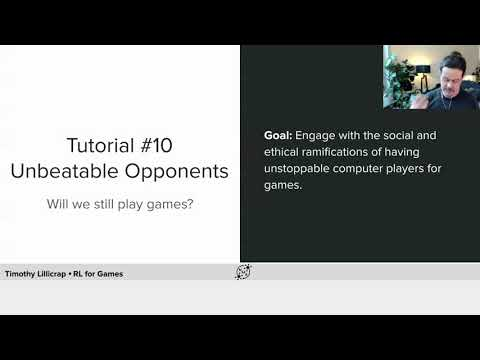

Video available at https://www.bilibili.com/video/BV19M4y1K75Z


In [60]:
# @title Video 9: Unbeatable opponents
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'q7181lvoNpM'), ('Bilibili', 'BV19M4y1K75Z')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [61]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Unbeatable_opponents_Video")

---
# Summary

In this tutorial, you have learned about:
*   the Othello game, how to implement a game loop, and create a random player.
*   value-based players and compared them to a random player.
*   policy-based players and compared them to random and value-based players.
*   players with Monte Carlo planner and compared them to random, value-based and policy-based players.

Video available at https://youtube.com/watch?v=uQ26iIUzmtw


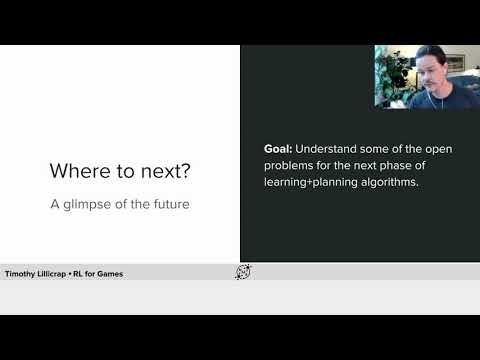

Video available at https://www.bilibili.com/video/BV1w64y167qd


In [62]:
# @title Video 19: Outro
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'uQ26iIUzmtw'), ('Bilibili', 'BV1w64y167qd')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [63]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Outro_Video")